### pca analysis (field data)
#### last modified: 7 nov 2025 (ry)

- perform pca for each taxonomic rank (phylum, class, order)
- plot in pc space, visualized by lake, depth and edge

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

C:\Users\ryann\AppData\Local\Temp\ipykernel_26252\1777700716.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## [RUN] functions 

def prepare_df_rank(df, rank:str):
    '''takes in df_field containing all observations (28848 rows), 
    and prepares a dataframe containing 16 rows (samples), and 
    col according to taxonomic rank
    '''
    df_rank = (df.groupby(['sample', rank, 'Lake', 'Edge', 'Depth', 'SampleType'], as_index=False)['Abundance'].sum())
    df_rank_wide = df_rank.pivot_table(
        index=['sample', 'Lake', 'Edge', 'Depth', 'SampleType'],  
        columns=rank,
        values='Abundance',
        fill_value=0  # fill missing abundance w/ 0
        ).reset_index()
    df_rank_wide.columns.name = None
    return df_rank_wide

def run_pca(df_taxa):
    '''takes in df output of prepare_df_rank and runs PCA analysis, 
    returns (a) fracvar, (b) pcs, (c) eigenvectors
    
    note that pca is run on a {m variable x n observations} matrix, where n = 16 (samples), and 
        - m = 100 for phylum 
        - m = 246 for class
        - m = 600 for order 
    
    there are 16 modes of variances (technically m modes, but python outputs min(m,n))
    each pc contains m elements, represents "taxa space"
    each eigenvector contains 16 elements, represents variations across samples 
    '''
    df_cols = df_taxa.columns.difference(['sample', 'Lake', 'Edge', 'Depth', 'SampleType']) # remove unnecessary cols for pca 
    X = df_taxa[df_cols].to_numpy() # shape: 16, m
    pca = PCA()                               
    PCs = pca.fit_transform(X)                                  
    eigvecs = pca.components_                       
    fracVar = pca.explained_variance_ratio_ 
    return fracVar, PCs, eigvecs

def run_pca_log(df_taxa, threshold = 0.35):
    '''similar to run_pca, but with additional preprocessing 
    1. keep only the relevant taxa (col) with >0 abudance in at least X% of samples 
    2. add pseudocount to zero values 
    3. transform data to a centered log-ratio (log, then subtract by sample mean)
        * idea here is to reflect how much more abundant a taxon is compared to the average of that sample
    4. standardize the data 
    '''
    # remove metadata from the df 
    meta_cols = ['sample', 'Lake', 'Edge', 'Depth', 'SampleType']  
    taxa_cols = df_taxa.columns.difference(meta_cols)
    X = df_taxa[taxa_cols].copy()        

    # keep taxa (col) that are found in at least 35% of samples  
    min_prev = max(1, int(np.ceil(threshold * X.shape[0])))       
    keep = (X > 0).sum(axis=0) >= min_prev
    X = X.loc[:, keep]

    # add pseudocount (for log later)
    pseudo = 1e-6
    X_pc = X + pseudo

    # centered log-ratio: log the data then subtract by sample mean (row)
    logX = np.log(X_pc)
    clr = logX.sub(logX.mean(axis=1), axis=0)  

    # standardize the data  
    scaler = StandardScaler(with_mean=True, with_std=True)
    clr_z = scaler.fit_transform(clr.values)  

    # run pca 
    pca = PCA() 
    PCs = pca.fit_transform(clr_z)                
    fracVar = pca.explained_variance_ratio_       
    eigvecs = pca.components_
    return fracVar, PCs, eigvecs                  

In [4]:
df_phylum

,sample,Lake,Edge,Depth,SampleType,4484-113,Acidobacteriota,Actinomycetota,Aenigmatarchaeota,Altiarchaeota,...,UBA1439,UBA3054,UBA6262,UBP14,UBP15,UBP4,VGIX01,Verrucomicrobiota,WOR-3,Zixibacteria
0,Inre_C_10_12,Inre,Center,10,Field,0.017288,6.311236,2.550339,0.031550,0.159045,...,0.411010,0.000000,0.000000,0.00000,0.088166,0.000000,0.000000,3.045626,0.201399,0.849249
1,Inre_C_14_16,Inre,Center,14,Field,0.055952,3.863552,1.596537,1.762971,0.469904,...,0.021812,0.055952,0.000000,0.00000,0.050736,0.088670,0.032244,2.454788,0.319592,0.812731
2,Inre_C_2_4,Inre,Center,2,Field,0.020039,4.666172,3.998986,0.350685,0.357758,...,0.000000,0.000000,0.030059,0.00000,0.023575,0.000000,0.026522,3.974821,0.253436,0.340665
3,Inre_C_6_8,Inre,Center,6,Field,0.027676,6.066444,11.671623,0.105820,0.104734,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.777356,0.137837,0.213810
4,Inre_E_14_16,Inre,Edge,14,Field,0.010479,5.489459,1.591299,0.300521,0.115268,...,0.177767,0.000000,0.000000,0.01497,0.141465,0.000000,0.000000,2.602141,0.234279,1.117502
5,Inre_E_2_4,Inre,Edge,2,Field,0.015590,5.672887,1.056445,1.764409,0.360402,...,0.000000,0.000000,0.000000,0.00000,0.031180,0.023385,0.000000,1.695172,0.658902,1.468201
6,Inre_E_6_8,Inre,Edge,6,Field,0.000000,5.915794,5.104068,0.868815,0.090390,...,0.000000,0.000000,0.000000,0.00000,0.020219,0.000000,0.000000,1.148906,0.706470,0.895576
7,Laksedre_E_10_12,Inre,Edge,10,Field,0.019146,6.257020,5.720498,0.120409,0.197845,...,0.000000,0.000000,0.000000,0.00000,0.017019,0.000000,0.015743,4.626179,0.354420,0.357824
8,Villa_C_10_12,Villa,Center,10,Field,0.000000,5.534583,14.055015,0.057951,0.072301,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.547630,0.177716,0.113694
9,Villa_C_14_16v2,Villa,Center,14,Field,0.020352,7.344674,4.815682,0.808118,0.121342,...,0.000000,0.000000,0.000000,0.00000,0.013056,0.007488,0.019584,1.468397,0.740919,1.089778


In [3]:
## [RUN] prepare dataframes 

df = pd.read_csv('microbe_data.csv')           # 28848 rows
df = df.iloc[:, 1:]                            # drop first col 
df_field = df[df['SampleType'] == 'Field']     # 9616 rows 
df_field = df_field[['taxonomy', 'sample',     # keep relevant cols
    'Abundance', 'Lake', 'Edge', 'Depth', 'SampleType']]

# split columns according to taxa 
tax_split = df_field['taxonomy'].str.split(';', expand=True)
tax_split.columns = ['Root', 'domain', 'phylum', 'class', 'order']
for col in ['domain', 'phylum', 'class', 'order']:
    tax_split[col] = tax_split[col].str.strip().str.replace(r'^[dpco]__', '', regex=True)
df_field = pd.concat([df_field, tax_split[['domain', 'phylum', 'class', 'order']]], axis=1)

df_phylum = prepare_df_rank(df_field, 'phylum') # 100 phylum 
df_class = prepare_df_rank(df_field, 'class')   # 246 phylum 
df_order = prepare_df_rank(df_field, 'order')   # 600 order 


In [21]:
## [RUN] pca 

# 1. pca with phylum 
#      16 pcs, 16 elements each
#      16 eigenvectors, m elements each
# fracVar_phylum, PCs_phylum, eigvecs_phylum = run_pca(df_phylum) # m = 100
fracVar_phylum, PCs_phylum, eigvecs_phylum = run_pca_log(df_phylum)

# 2. pca with class 
#      16 pcs, 16 elements each
#      16 eigenvectors, m elements each
# fracVar_class, PCs_class, eigvecs_class = run_pca(df_class) # m = 246
fracVar_class, PCs_class, eigvecs_class = run_pca_log(df_class)

# 3. pca with order 
#      16 pcs, 16 elements each
#      16 eigenvectors, m elements each
# fracVar_order, PCs_order, eigvecs_order = run_pca(df_order) # m = 600
fracVar_order, PCs_order, eigvecs_order = run_pca_log(df_order)

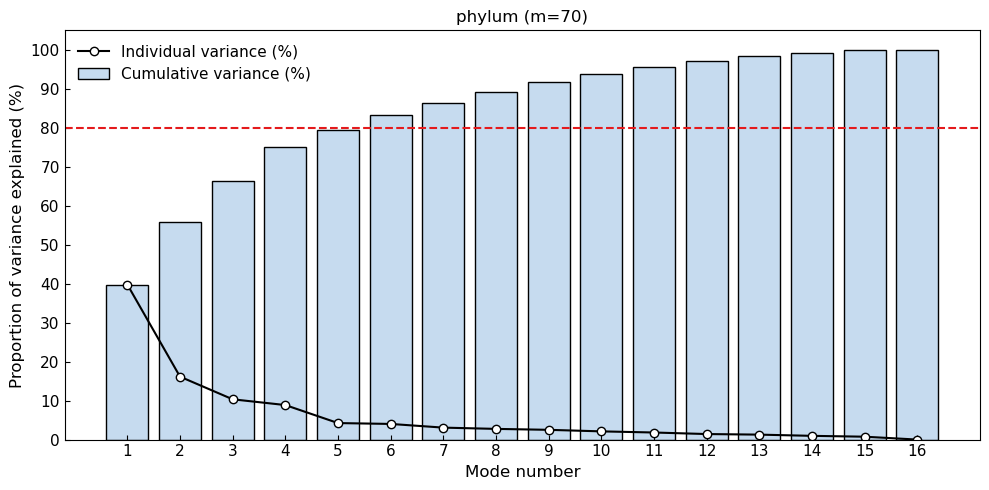

In [29]:
explained_var = 100 * fracVar_phylum                       
cumulative_var = 100 * np.cumsum(fracVar_phylum)            
pcs = np.arange(1, len(fracVar_phylum) + 1)                 

# Bar colors: first 8 darker, rest lighter
# bar_colors = ['#6baed6' if i < 8 else '#c6dbef' for i in range(len(pcs))]
bar_colors = ['#c6dbef']

fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot: cumulative variance (%)
ax.bar(pcs, cumulative_var, alpha=1, label='Cumulative variance (%)',
       color=bar_colors, edgecolor='black', linewidth=1)

# Line plot: individual variance (%)
ax.plot(pcs, explained_var, marker='o', color='k', mfc='white',
        label='Individual variance (%)')

# 90% threshold line
ax.axhline(y=80, color='#e41a1c', linestyle='--', linewidth=1.5)

# Axes/legend
ax.set_xlabel('Mode number', fontsize=12)
ax.set_ylabel('Proportion of variance explained (%)', fontsize=12)
ax.set_xticks(pcs)
ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(frameon=False, fontsize=11)
ax.set_title(f'phylum (m={eigvecs_phylum.shape[1]})')

# Style
ax.tick_params(axis='both', direction='in', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.show()


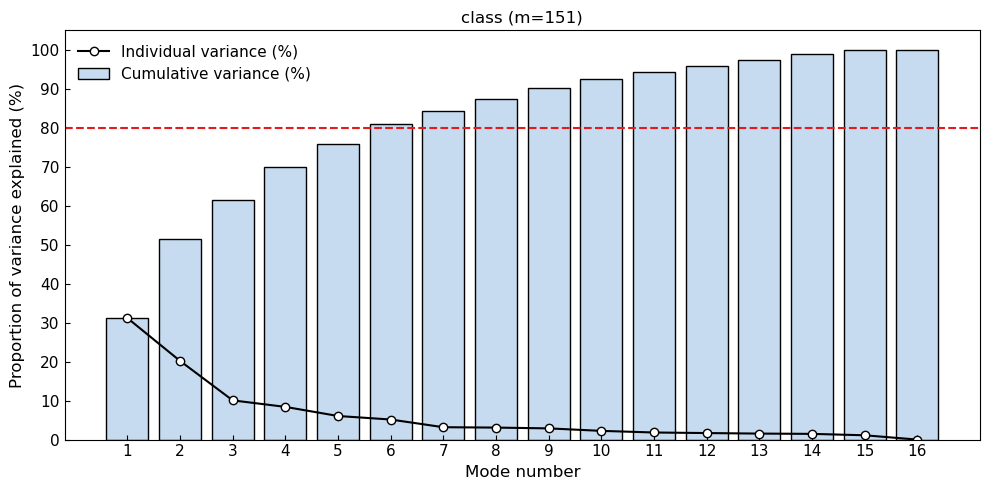

In [30]:
explained_var = 100 * fracVar_class                        
cumulative_var = 100 * np.cumsum(fracVar_class)            
pcs = np.arange(1, len(fracVar_class) + 1)                 

# Bar colors: first 8 darker, rest lighter
# bar_colors = ['#6baed6' if i < 8 else '#c6dbef' for i in range(len(pcs))]
bar_colors = ['#c6dbef']

fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot: cumulative variance (%)
ax.bar(pcs, cumulative_var, alpha=1, label='Cumulative variance (%)',
       color=bar_colors, edgecolor='black', linewidth=1)

# Line plot: individual variance (%)
ax.plot(pcs, explained_var, marker='o', color='k', mfc='white',
        label='Individual variance (%)')

# 90% threshold line
ax.axhline(y=80, color='#e41a1c', linestyle='--', linewidth=1.5)

# Axes/legend
ax.set_xlabel('Mode number', fontsize=12)
ax.set_ylabel('Proportion of variance explained (%)', fontsize=12)
ax.set_xticks(pcs)
ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(frameon=False, fontsize=11)
ax.set_title(f'class (m={eigvecs_class.shape[1]})')

# Style
ax.tick_params(axis='both', direction='in', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.show()

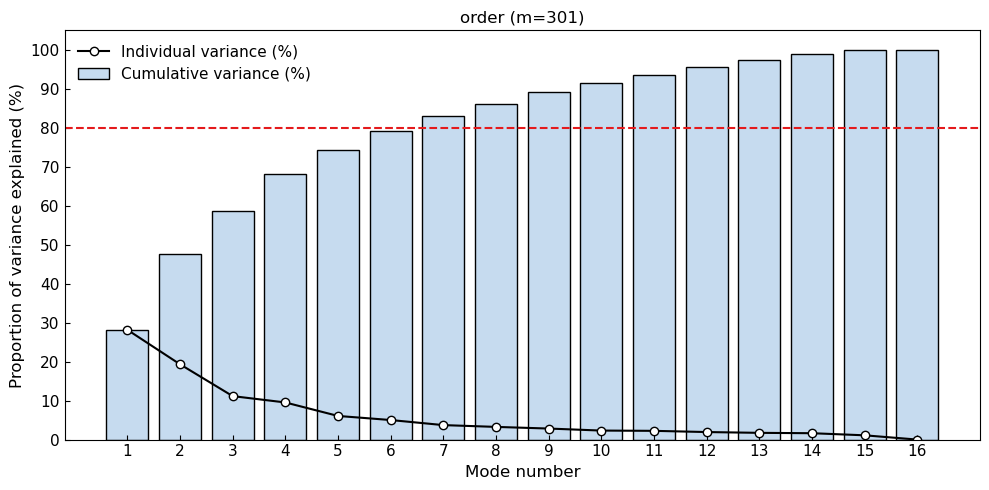

In [31]:
explained_var = 100 * fracVar_order                    
cumulative_var = 100 * np.cumsum(fracVar_order)            
pcs = np.arange(1, len(fracVar_order) + 1)                 

# Bar colors: first 8 darker, rest lighter
# bar_colors = ['#6baed6' if i < 8 else '#c6dbef' for i in range(len(pcs))]
bar_colors = ['#c6dbef']

fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot: cumulative variance (%)
ax.bar(pcs, cumulative_var, alpha=1, label='Cumulative variance (%)',
       color=bar_colors, edgecolor='black', linewidth=1)

# Line plot: individual variance (%)
ax.plot(pcs, explained_var, marker='o', color='k', mfc='white',
        label='Individual variance (%)')

# 90% threshold line
ax.axhline(y=80, color='#e41a1c', linestyle='--', linewidth=1.5)

# Axes/legend
ax.set_xlabel('Mode number', fontsize=12)
ax.set_ylabel('Proportion of variance explained (%)', fontsize=12)
ax.set_xticks(pcs)
ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(frameon=False, fontsize=11)
ax.set_title(f'order (m={eigvecs_order.shape[1]})')

# Style
ax.tick_params(axis='both', direction='in', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.show()

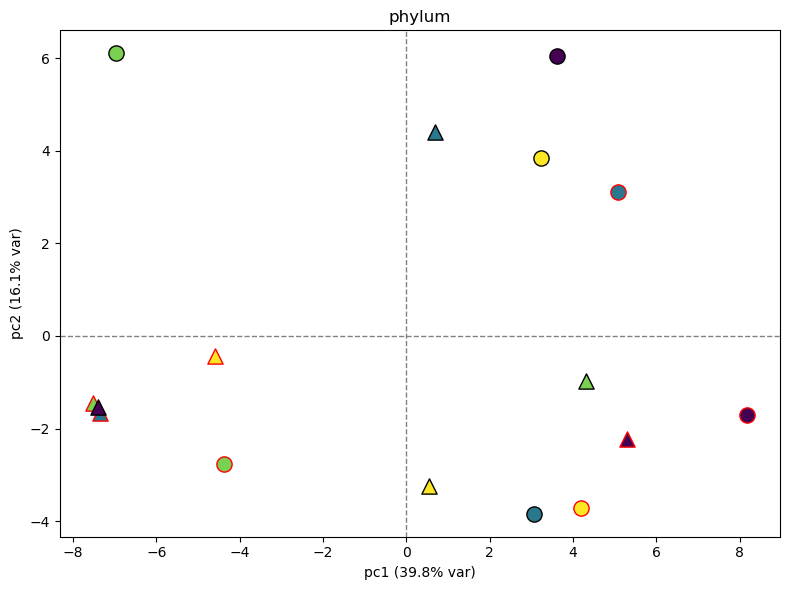

In [32]:
# define labels 
sample_labels = df_phylum['sample']
lake = df_phylum['Lake']
depth = df_phylum['Depth']
edge = df_phylum['Edge']

# define mappings 
lake_marker = {'Inre': 'o', 'Villa': '^'}
depth_color = {2: '#fde725', 6: '#7ad151', 10: '#2a788e', 14: '#440154'}
edge_border = {'Center': 'red', 'Edge': 'black'}

# plot 
plt.figure(figsize=(8, 6))
for i in range(len(df_phylum)):
    plt.scatter(
        PCs_phylum[i, 0],
        PCs_phylum[i, 1],
        s=120,
        marker=lake_marker.get(lake.iloc[i], 'o'),
        facecolor=depth_color.get(depth.iloc[i], 'gray'),
        edgecolor=edge_border.get(edge.iloc[i], 'black'),
        linewidth=1,
        zorder=3
    )

# axis labels 
plt.xlabel(f'pc1 ({fracVar_phylum[0]*100:.1f}% var)')
plt.ylabel(f'pc2 ({fracVar_phylum[1]*100:.1f}% var)')
plt.title('phylum')

plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
plt.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.show()

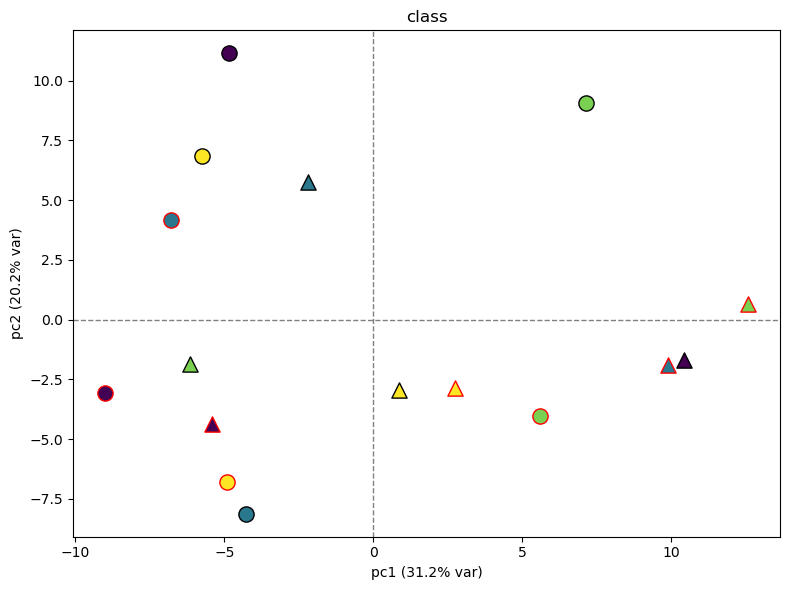

In [33]:
# define labels 
sample_labels = df_class['sample']
lake = df_class['Lake']
depth = df_class['Depth']
edge = df_class['Edge']

# define mappings 
lake_marker = {'Inre': 'o', 'Villa': '^'}
depth_color = {2: '#fde725', 6: '#7ad151', 10: '#2a788e', 14: '#440154'}
edge_border = {'Center': 'red', 'Edge': 'black'}

# plot 
plt.figure(figsize=(8, 6))
for i in range(len(df_class)):
    plt.scatter(
        PCs_class[i, 0],
        PCs_class[i, 1],
        s=120,
        marker=lake_marker.get(lake.iloc[i], 'o'),
        facecolor=depth_color.get(depth.iloc[i], 'gray'),
        edgecolor=edge_border.get(edge.iloc[i], 'black'),
        linewidth=1,
        zorder=3
    )

# axis labels 
plt.xlabel(f'pc1 ({fracVar_class[0]*100:.1f}% var)')
plt.ylabel(f'pc2 ({fracVar_class[1]*100:.1f}% var)')
plt.title('class')

plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
plt.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.show()


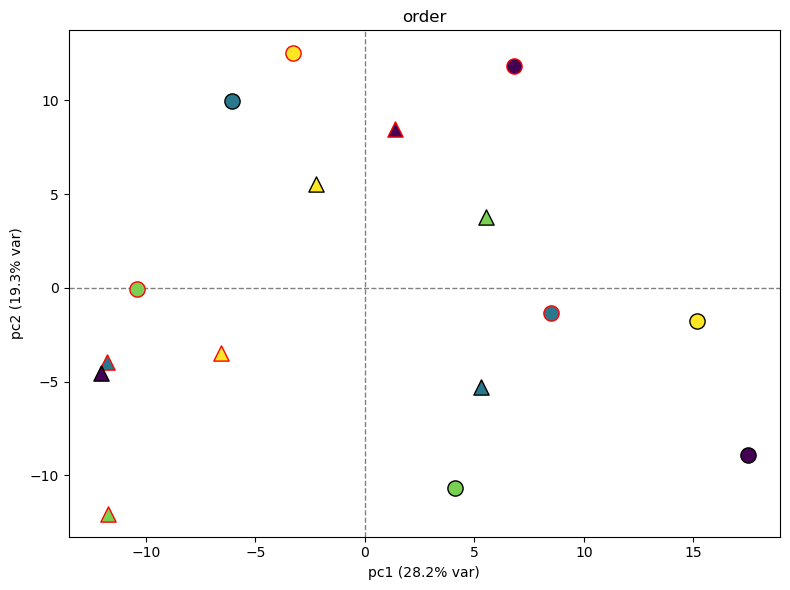

In [34]:
# define labels 
sample_labels = df_order['sample']
lake = df_order['Lake']
depth = df_order['Depth']
edge = df_order['Edge']

# define mappings 
lake_marker = {'Inre': 'o', 'Villa': '^'}
depth_color = {2: '#fde725', 6: '#7ad151', 10: '#2a788e', 14: '#440154'}
edge_border = {'Center': 'red', 'Edge': 'black'}

# plot 
plt.figure(figsize=(8, 6))
for i in range(len(df_order)):
    plt.scatter(
        PCs_order[i, 0],
        PCs_order[i, 1],
        s=120,
        marker=lake_marker.get(lake.iloc[i], 'o'),
        facecolor=depth_color.get(depth.iloc[i], 'gray'),
        edgecolor=edge_border.get(edge.iloc[i], 'black'),
        linewidth=1,
        zorder=3
    )

# axis labels 
plt.xlabel(f'pc1 ({fracVar_order[0]*100:.1f}% var)')
plt.ylabel(f'pc2 ({fracVar_order[1]*100:.1f}% var)')
plt.title('order')

plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
plt.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.show()

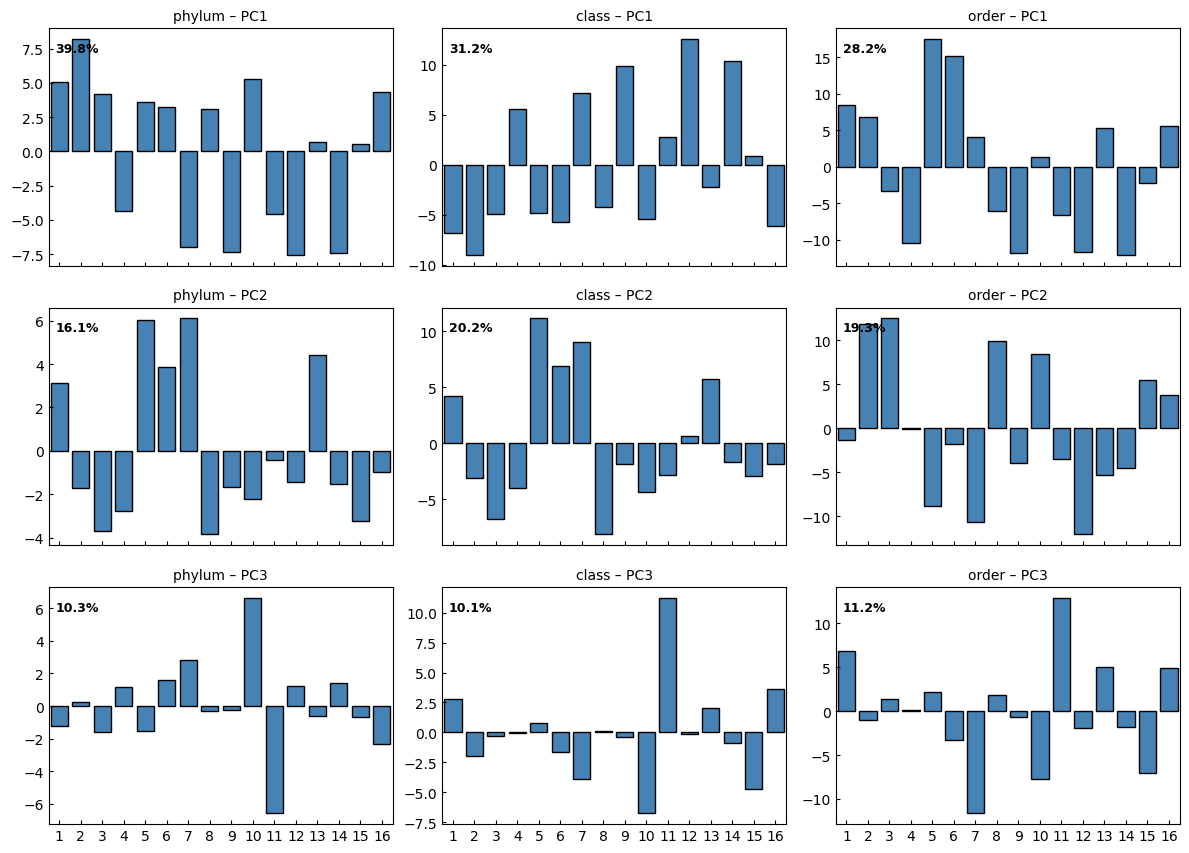

In [35]:
# Define names and data to iterate easily
datasets = [
    ('phylum', PCs_phylum, fracVar_phylum),
    ('class',  PCs_class,  fracVar_class),
    ('order',  PCs_order,  fracVar_order)
]

fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
for row in range(3):  # pc1-3 
    for col, (name, PCs, fracVar) in enumerate(datasets):
        ax = axes[row, col]
        ax.bar(np.arange(1, 17), PCs[:, row], color='steelblue', edgecolor='k')
        ax.set_title(f'{name} – PC{row+1}', fontsize=10)
        ax.set_xticks(range(1, 17))
        ax.tick_params(axis='x', direction='in', length=3)
        ax.tick_params(axis='y', direction='in', length=3)
        ax.set_xlim(0.5, 16.5)
        ax.text(0.02, 0.9, f'{fracVar[row]*100:.1f}%', transform=ax.transAxes, fontsize=9, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# print out zeros 

# df_cols1 = df_phylum.columns.difference(['sample', 'Lake', 'Edge', 'Depth', 'SampleType']) # remove unnecessary cols for pca 
# X1 = df_phylum[df_cols1].to_numpy() # shape: 16, m
# print(f'phylum zeros: {np.sum(X1 == 0)}, {np.sum(X1 == 0) / (X1.shape[0] * X1.shape[1]) * 100}%')

# df_cols2 = df_class.columns.difference(['sample', 'Lake', 'Edge', 'Depth', 'SampleType']) # remove unnecessary cols for pca 
# X2 = df_class[df_cols2].to_numpy() # shape: 16, m
# print(f'class zeros: {np.sum(X2 == 0)}, {np.sum(X2 == 0) / (X2.shape[0] * X2.shape[1]) * 100}%')

# df_cols3 = df_order.columns.difference(['sample', 'Lake', 'Edge', 'Depth', 'SampleType']) # remove unnecessary cols for pca 
# X3 = df_order[df_cols3].to_numpy() # shape: 16, m
# print(f'order zeros: {np.sum(X3 == 0)}, {np.sum(X3 == 0) / (X3.shape[0] * X3.shape[1]) * 100}%')


phylum zeros: 639, 39.9375%
class zeros: 1895, 48.14532520325203%
order zeros: 5440, 56.666666666666664%
